In [3]:
# Parameters
hidden_size = 43
num_layers = 8
activation = "tanh"
n_samples_PDE = 8723
n_samples_data = 434
skip_connections = False
seed = 3
num_epochs_adam = 1095
num_epochs_lbfgs = 3000

n_samples_data_val = int(1e+3)
n_samples_PDE_val = int(1e+4)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt


# Verifica se a GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveletActivation(nn.Module):
    def __init__(self, hidden_size):
        super(WaveletActivation, self).__init__()
        # Pesos para sin(x) e cos(x) com valores próximos a 1
        self.w1 = nn.Parameter(torch.ones(hidden_size), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(hidden_size), requires_grad=True)        

    def forward(self, x):
        return self.w1 * torch.sin(x) + self.w2 * torch.cos(x)

class PINN(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_layers, skip_connections, activation='tanh'):
        super(PINN, self).__init__()

        self.skip_connections = skip_connections
        if skip_connections:
            self.fc_u = nn.Linear(input_size, hidden_units[0])
            self.fc_v = nn.Linear(input_size, hidden_units[0])
        
        # Inicialização das funções de ativação para U e V
        if activation == 'wavelet':
            self.activation_u = WaveletActivation(hidden_units[0]) if skip_connections else None
            self.activation_v = WaveletActivation(hidden_units[0]) if skip_connections else None
        elif activation == 'relu':
            self.activation_u = nn.ReLU() if skip_connections else None
            self.activation_v = nn.ReLU() if skip_connections else None
        elif activation == 'tanh':
            self.activation_u = nn.Tanh() if skip_connections else None
            self.activation_v = nn.Tanh() if skip_connections else None
        else:
            raise ValueError("Função de ativação inválida. Escolha entre 'relu', 'tanh' ou 'wavelet'.")

        # Define camadas principais e ativações
        self.main_layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        
        # Primeira camada oculta
        self.main_layers.append(nn.Linear(input_size, hidden_units[0]))

        # Adiciona ativação para a primeira camada
        if activation == 'relu':
            self.activations.append(nn.ReLU())
        elif activation == 'tanh':
            self.activations.append(nn.Tanh())
        elif activation == 'wavelet':
            self.activations.append(WaveletActivation(hidden_units[0]))        
        
        # Camadas ocultas adicionais
        for i in range(1, len(hidden_units)):
            self.main_layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            # Adiciona ativação conforme necessário
            if activation == 'relu':
                self.activations.append(nn.ReLU())
            elif activation == 'tanh':
                self.activations.append(nn.Tanh())
            elif activation == 'wavelet':
                self.activations.append(WaveletActivation(hidden_units[i]))

        # Camada de saída
        self.output_layer = nn.Linear(hidden_units[-1], output_size)

    def forward(self, x, u):
        # Concatenando entrada
        inputs = torch.cat([x, u], dim=1)
        
        if self.skip_connections:
            U = self.activation_u(self.fc_u(inputs))
            V = self.activation_v(self.fc_v(inputs))
        
        A = inputs

        # Loop sobre camadas e ativações
        for z_layer, activation in zip(self.main_layers, self.activations):
            Z = activation(z_layer(A))
            if self.skip_connections:
                A = (1 - Z) * U + Z * V
            else:
                A = Z

        # Saída final
        y = self.output_layer(A)
        return y


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim
import lhs


# Verifica se a GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
def pinn_loss(model, x, u):

    x.requires_grad_(True)
        
    # Outputs
    outputs = model(x, u)
    P_hat = outputs[:, 0:1]  # Pressão normalizada
    V_hat = outputs[:, 1:2]  # Velocidade normalizada
    
    rho_hat = P_hat * P_ref / R / T / rho_ref
    
    
    # Derivatives with respect to normalized x
    P_x = torch.autograd.grad(P_hat, x, grad_outputs=torch.ones_like(P_hat), create_graph=True)[0] 
    V_x = torch.autograd.grad(V_hat, x, grad_outputs=torch.ones_like(V_hat), create_graph=True)[0] 
    rhoV2_x = torch.autograd.grad(rho_hat * V_hat**2, x, grad_outputs=torch.ones_like(V_hat), create_graph=True)[0] 
    rhoV_x = torch.autograd.grad(rho_hat * V_hat, x, grad_outputs=torch.ones_like(V_hat), create_graph=True)[0] 
    
    # Reynolds number calculation
    epsilon = 1e-12
    Re = rho_hat * rho_ref * V_hat * V_ref * D / (mu + epsilon)
    
    # Clamping
    Re = torch.clamp(Re, min=epsilon) #, max=1e10)
    
    # Friction factor (Swamee-Jain, eps/D = 0)

    f = torch.where(
            Re > 2000,
            0.25 / ((-0.9 * torch.log10(Re) + torch.log10(torch.tensor(5.74))) ** 2),  # Swamee–Jain para Re < 1e5
            64.0 / Re   # Laminar
        )
    
    f = torch.clamp(f, min = 0, max = 0.1)
    
    
    # Normalized Equations
    eq1 = rhoV_x  # Balanço de massa normalizado
    
    
    eq2 = rhoV2_x              + P_x * P_ref / (rho_ref * V_ref**2) + 0.5 * f * x_ref * rho_hat * V_hat * torch.abs(V_hat) / D

        
    # Calcular as perdas (função de custo)
    loss_eq1 = torch.mean(eq1**2)
    loss_eq2 = torch.mean(eq2**2)
    
    total_loss = loss_eq1 + loss_eq2 
    
    d = {'mass_loss': loss_eq1,
         'momentum_loss': loss_eq2,
        }

    
    return total_loss, d
    

# Função para calcular a perda das condições de contorno
def boundary_conditions_loss(model, x_val_0, x_val_1, u0, u1):
    
    P_pred_0 = model(x_val_0, u0)[:, 0:1]
    V_pred_0 = model(x_val_0, u0)[:, 1:2]

    
    rho_pred_0 = P_pred_0 * P_ref / R / T / rho_ref
    
    rhoV_ipr = k * (Pest - P_pred_0*P_ref)
    
    
    loss_bc1 = torch.mean((rho_pred_0 * V_pred_0 - rhoV_ipr/V_ref/rho_ref)**2) #condicao de contorno com vazao massica
    
    # x = 1 for P(x=1, t) = 1
    P_pred_1 = model(x_val_1, u1)[:, 0:1]
    loss_bc2 = torch.mean((P_pred_1 - u1)**2)  ## abriu ou fechou um pouco a válvula no instante zero
    
    
    total_loss = loss_bc1 + loss_bc2 
    
    d = {'loss_upstream': loss_bc1,
         'loss_downstream_P': loss_bc2,
        }
    
    
    return total_loss, d


#Reference Values and study parameters
P_ref = 50e5  # Pa
V_ref = 50  # m/s
rho_ref = 60  # kg/m³
x_ref = 2000  # Reference length
D = 0.20  # Diameter
R = 287  # Gas Constant J/(kg·K)
T = 300  # Temperature, K
mu = 5.0e-5  # Viscosity assumed fixed
k = 5e-4 # mass Productivity Index , PI (kg/s/Pa)
Pest = 50e+5 # static pressure (Pa)






Collocation and boundary points generation

In [6]:
import numpy as np
from scipy.stats import qmc



def generate_collocation_points(n_samples, seed):
    
    dimensions = 2 # LHS for x and u

    sampler = qmc.LatinHypercube(d=dimensions, seed=seed)
    lhs_sample = sampler.random(n=n_samples)
    

    x_points = lhs_sample[:, 0]  
    u_points = lhs_sample[:, 1]  


    x_tensor = torch.tensor(x_points, dtype=torch.float32).reshape(-1,1).to(device)
    u_tensor = torch.tensor(u_points, dtype=torch.float32).reshape(-1,1).to(device)

    u_tensor = 0.8 * u_tensor + 0.20 #ranging from 0.2 to 1.0 (meaningful range for u)
    
    return x_tensor, u_tensor

def generate_data_points(n_samples, seed):
    
    dimensions = 1  # LHS for u for x = 0 and x = 1 (boundaries)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # LHS for u (x = 0)
    sampler = qmc.LatinHypercube(d=dimensions, seed=seed)
    u_sample = sampler.random(n=n_samples)
    u_tensor_bc_0 = torch.tensor(u_sample[:, 0], dtype=torch.float32).reshape(-1,1).to(device)

    # LHS for u (x = 1)
    sampler = qmc.LatinHypercube(d=dimensions, seed=2*seed)
    u_sample = sampler.random(n=n_samples)
    u_tensor_bc_1 = torch.tensor(u_sample[:, 0], dtype=torch.float32).reshape(-1,1).to(device)

    # Tensors for x = 0 and x = 1
    x_0_tensor = torch.zeros(n_samples, dtype=torch.float32).reshape(-1,1).to(device)  # x = 0 for all points
    x_1_tensor = torch.ones(n_samples, dtype=torch.float32).reshape(-1,1).to(device)  # x = 1 for all points
    
    #Ranging from 10 to 50 bar
    u_tensor_bc_0 = 0.8 * u_tensor_bc_0 + 0.2
    u_tensor_bc_1 = 0.8 * u_tensor_bc_1 + 0.2
    
    return x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1
    
    
    
    
    

In [7]:
x_tensor, u_tensor = generate_collocation_points(n_samples_PDE, seed)
x_tensor_val, u_tensor_val = generate_collocation_points(n_samples_PDE_val, 25)


x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1 = generate_data_points(n_samples_data, seed)
x_0_tensor_val, x_1_tensor_val, u_tensor_bc_0_val, u_tensor_bc_1_val = generate_data_points(n_samples_data_val, 26)



Training

In [8]:
import torch.optim as optim
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.init as init

#Seed is provided, the initial weights depend on the seed.
torch.manual_seed(seed)            
model = PINN(input_size = 2, hidden_units = [hidden_size]*num_layers, output_size=2, num_layers=num_layers, skip_connections=skip_connections, activation=activation)
model = model.to(device)

best_loss = float('inf')
best_model_path = "best_model.pth"

# Loop para contar e imprimir os parâmetros do modelo
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_params = param.numel()  # Number of parameters for each layer
        print(f"Layer: {name} | Parameters: {layer_params}")
        total_params += layer_params

print(f"\nTotal of trainable parameters: {total_params}")


Layer: main_layers.0.weight | Parameters: 86
Layer: main_layers.0.bias | Parameters: 43
Layer: main_layers.1.weight | Parameters: 1849
Layer: main_layers.1.bias | Parameters: 43
Layer: main_layers.2.weight | Parameters: 1849
Layer: main_layers.2.bias | Parameters: 43
Layer: main_layers.3.weight | Parameters: 1849
Layer: main_layers.3.bias | Parameters: 43
Layer: main_layers.4.weight | Parameters: 1849
Layer: main_layers.4.bias | Parameters: 43
Layer: main_layers.5.weight | Parameters: 1849
Layer: main_layers.5.bias | Parameters: 43
Layer: main_layers.6.weight | Parameters: 1849
Layer: main_layers.6.bias | Parameters: 43
Layer: main_layers.7.weight | Parameters: 1849
Layer: main_layers.7.bias | Parameters: 43
Layer: output_layer.weight | Parameters: 86
Layer: output_layer.bias | Parameters: 2

Total of trainable parameters: 13461


First training with Adam for further refinement with L-BFGS.

In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6)


# List for losses (training)
loss_bc_list = []
loss_pde_list = []
total_loss_list = []

# List for losses (validation)
val_loss_bc_list = []
val_loss_pde_list = []
val_total_loss_list = []


# Training with Adam
for epoch in range(num_epochs_adam + 1):
    model.train()  # Training mode
    optimizer.zero_grad()

    # Loss calculation in training dataset
    loss_pde, loss_components_pde = pinn_loss(model, x_tensor, u_tensor)
    loss_bc, loss_components_bc = boundary_conditions_loss(model, x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1)
    loss = loss_pde + loss_bc  # Perda total combinada

    # Backpropagation and weights update
    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()

    # Appending the results
    loss_bc_list.append({f"bc_{k}": v.item() for k, v in loss_components_bc.items()})
    loss_pde_list.append({f"pde_{k}": v.item() for k, v in loss_components_pde.items()})
    total_loss_list.append({"total_loss": loss.item()})
    
    model.eval()  # mode evaluation for the validation dataset

    # detach x_tensor_val
    x_tensor_val = x_tensor_val.clone().detach().requires_grad_(True)

    # Losses calculation for validation dataset
    val_loss_pde, val_loss_components_pde = pinn_loss(model, x_tensor_val, u_tensor_val)
    val_loss_bc, val_loss_components_bc = boundary_conditions_loss(model, x_0_tensor_val, x_1_tensor_val, u_tensor_bc_0_val, u_tensor_bc_1_val)
    val_loss = val_loss_pde + val_loss_bc  # Perda total de validação

    # Appending the results
    val_loss_bc_list.append({f"bc_{k}": v.item() for k, v in val_loss_components_bc.items()})
    val_loss_pde_list.append({f"pde_{k}": v.item() for k, v in val_loss_components_pde.items()})
    val_total_loss_list.append({"total_loss": val_loss.item()})    


    # Show progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.1e}, Learning Rate = {optimizer.param_groups[0]['lr']:.1e}")
    
    # Learning Rate updates with scheduler
    scheduler.step(loss)



Epoch 0: Total Loss = 8.5e-01, Learning Rate = 1.0e-03
Epoch 100: Total Loss = 5.0e-02, Learning Rate = 1.0e-03
Epoch 200: Total Loss = 3.6e-02, Learning Rate = 1.0e-03
Epoch 300: Total Loss = 2.7e-02, Learning Rate = 1.0e-03
Epoch 400: Total Loss = 2.5e-02, Learning Rate = 1.0e-03
Epoch 500: Total Loss = 2.0e-02, Learning Rate = 1.0e-03
Epoch 600: Total Loss = 1.8e-02, Learning Rate = 1.0e-03
Epoch 700: Total Loss = 9.1e-02, Learning Rate = 1.0e-03
Epoch 800: Total Loss = 1.3e-02, Learning Rate = 1.0e-03
Epoch 900: Total Loss = 1.3e-02, Learning Rate = 1.0e-03
Epoch 1000: Total Loss = 1.4e-02, Learning Rate = 1.0e-03


Refinement with L-BFGS

In [10]:
lbfgs_optimizer = optim.LBFGS(
    model.parameters(),
    lr=0.01,                  
    max_iter=num_epochs_lbfgs,            
    history_size=100,          
    line_search_fn="strong_wolfe",  
    tolerance_change=1e-50,    
    tolerance_grad=1e-50      
)


epoch_lbfgs = 0

def closure():

    global epoch_lbfgs  
    
    epoch_lbfgs += 1
    
    lbfgs_optimizer.zero_grad()
    
    # Losses calculation
    loss_pde, loss_components_pde = pinn_loss(model, x_tensor, u_tensor)
    loss_bc, loss_components_bc = boundary_conditions_loss(model, x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1)
    loss = loss_pde + loss_bc
    
    loss_bc_list.append({f"bc_{k}": v.item() for k, v in loss_components_bc.items()})
    loss_pde_list.append({f"pde_{k}": v.item() for k, v in loss_components_pde.items()})
    total_loss_list.append({"total_loss": loss.item()})

    # Losses in the validation dataset
    model.eval()

    x_tensor_val_grad = x_tensor_val.clone().detach().requires_grad_(True)

    # Validation losses calculation
    val_loss_pde, val_loss_components_pde = pinn_loss(model, x_tensor_val_grad, u_tensor_val)
    val_loss_bc, val_loss_components_bc = boundary_conditions_loss(model, x_0_tensor_val, x_1_tensor_val, u_tensor_bc_0_val, u_tensor_bc_1_val)
    val_loss = val_loss_pde + val_loss_bc  # Perda total de validação

    val_loss_bc_list.append({f"bc_{k}": v.item() for k, v in val_loss_components_bc.items()})
    val_loss_pde_list.append({f"pde_{k}": v.item() for k, v in val_loss_components_pde.items()})
    val_total_loss_list.append({"total_loss": val_loss.item()})

    model.train()  # Back to training mode
    
    if epoch_lbfgs % 100 == 0:
        print(f"Step {epoch_lbfgs}, Loss: {loss:.1e}")
    
    loss.backward()
    return loss

In [11]:
for i in range(3):

    lbfgs_optimizer.step(closure)  # call closure for optimization

Step 100, Loss: 9.5e-03
Step 200, Loss: 8.4e-03
Step 300, Loss: 7.7e-03
Step 400, Loss: 6.8e-03
Step 500, Loss: 4.2e-03
Step 600, Loss: 3.8e-03
Step 700, Loss: 3.6e-03
Step 800, Loss: 2.6e-03
Step 900, Loss: 2.3e-03
Step 1000, Loss: 1.8e-03
Step 1100, Loss: 1.6e-03
Step 1200, Loss: 1.4e-03
Step 1300, Loss: 1.3e-03
Step 1400, Loss: 1.3e-03
Step 1500, Loss: 1.2e-03
Step 1600, Loss: 1.0e-03
Step 1700, Loss: 8.5e-04
Step 1800, Loss: 6.6e-04
Step 1900, Loss: 4.9e-04
Step 2000, Loss: 4.1e-04
Step 2100, Loss: 3.2e-04
Step 2200, Loss: 3.0e-04
Step 2300, Loss: 2.8e-04
Step 2400, Loss: 2.7e-04
Step 2500, Loss: 2.7e-04
Step 2600, Loss: 2.6e-04
Step 2700, Loss: 2.3e-04
Step 2800, Loss: 1.9e-04
Step 2900, Loss: 1.8e-04
Step 3000, Loss: 1.8e-04
Step 3100, Loss: 1.7e-04
Step 3200, Loss: 1.6e-04
Step 3300, Loss: 1.5e-04
Step 3400, Loss: 1.5e-04
Step 3500, Loss: 1.4e-04
Step 3600, Loss: 1.3e-04
Step 3700, Loss: 1.3e-04
Step 3800, Loss: 1.3e-04
Step 3900, Loss: 1.2e-04
Step 4000, Loss: 1.1e-04
Step 4100

Mass and momentum losses

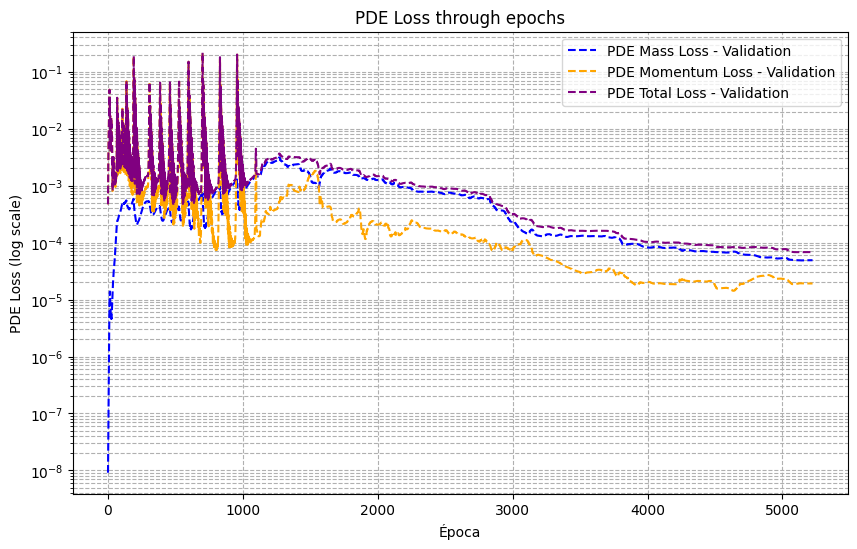

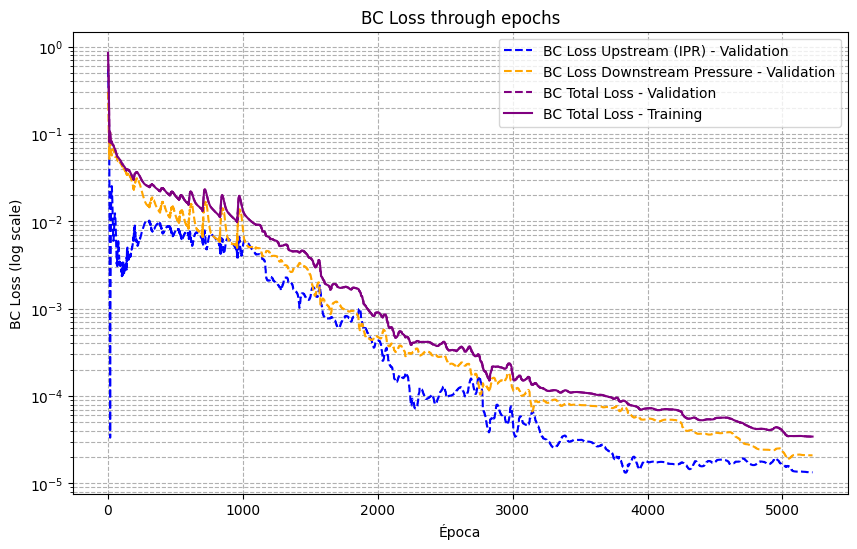

In [13]:
# Extrair as componentes da PDE Loss para treino
pde_mass_loss = [epoch_loss["pde_mass_loss"] for epoch_loss in loss_pde_list]
pde_momentum_loss = [epoch_loss["pde_momentum_loss"] for epoch_loss in loss_pde_list]
#pde_eos_loss = [epoch_loss["pde_eos_loss"] for epoch_loss in loss_pde_list]
pde_total_loss = [sum(epoch.values()) for epoch in loss_pde_list]  # Soma das componentes para obter o total

# Extrair as componentes da PDE Loss para validação
val_pde_mass_loss = [epoch_loss["pde_mass_loss"] for epoch_loss in val_loss_pde_list]
val_pde_momentum_loss = [epoch_loss["pde_momentum_loss"] for epoch_loss in val_loss_pde_list]
#val_pde_eos_loss = [epoch_loss["pde_eos_loss"] for epoch_loss in val_loss_pde_list]
val_pde_total_loss = [sum(epoch.values()) for epoch in val_loss_pde_list]  # Soma das componentes para obter o total

# Extrair as componentes da BC Loss para treino
bc_loss_upstream = [epoch_loss["bc_loss_upstream"] for epoch_loss in loss_bc_list]
bc_loss_downstream_P = [epoch_loss["bc_loss_downstream_P"] for epoch_loss in loss_bc_list]
#bc_loss_downstream_Rho = [epoch_loss["bc_loss_downstream_Rho"] for epoch_loss in loss_bc_list]
bc_total_loss = [sum(epoch.values()) for epoch in loss_bc_list]  # Soma das componentes para obter o total

# Extrair as componentes da BC Loss para validação
val_bc_loss_upstream = [epoch_loss["bc_loss_upstream"] for epoch_loss in loss_bc_list]
val_bc_loss_downstream_P = [epoch_loss["bc_loss_downstream_P"] for epoch_loss in loss_bc_list]
#val_bc_loss_downstream_Rho = [epoch_loss["bc_loss_downstream_Rho"] for epoch_loss in loss_bc_list]
val_bc_total_loss = [sum(epoch.values()) for epoch in loss_bc_list]  # Soma das componentes para obter o total

epochs = np.arange(1, len(loss_pde_list) + 1)


# Gráfico para PDE Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_pde_mass_loss, '--', label="PDE Mass Loss - Validation", color='blue')
#plt.plot(epochs, pde_mass_loss, label="PDE Mass Loss - Training", color='blue')

plt.plot(epochs, val_pde_momentum_loss, '--', label="PDE Momentum Loss - Validation", color='orange')
#plt.plot(epochs, pde_momentum_loss, label="PDE Momentum Loss - Training", color='orange')

#plt.plot(epochs, val_pde_eos_loss, '--', label="PDE EOS Loss - Validation", color='green')
#plt.plot(epochs, pde_eos_loss, label="PDE EOS Loss - Training", color='green')

plt.plot(epochs, val_pde_total_loss, '--', label="PDE Total Loss - Validation", color='purple')
#plt.plot(epochs, pde_total_loss,  label="PDE Total Loss - Training", color='purple')
plt.yscale('log')
plt.xlabel("Época")
plt.ylabel("PDE Loss (log scale)")
plt.title("PDE Loss through epochs")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()





# Gráfico para BC Loss com padrões similares ao gráfico de PDE Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_bc_loss_upstream, '--', label="BC Loss Upstream (IPR) - Validation", color='blue')
#plt.plot(epochs, bc_loss_upstream, label="BC Loss Upstream (IPR) - Training", color='blue')

plt.plot(epochs, val_bc_loss_downstream_P, '--', label="BC Loss Downstream Pressure - Validation", color='orange')
#plt.plot(epochs, bc_loss_downstream_P, label="BC Loss Downstream Pressure - Training", color='orange')

#plt.plot(epochs, val_bc_loss_downstream_Rho, '--', label="BC Loss Downstream Density - Validation", color='green')
#plt.plot(epochs, bc_loss_downstream_Rho, label="BC Loss Downstream Density - Training", color='green')

plt.plot(epochs, val_bc_total_loss, '--', label="BC Total Loss - Validation", color='purple')
plt.plot(epochs, bc_total_loss, label="BC Total Loss - Training", color='purple')
plt.yscale('log')
plt.xlabel("Época")
plt.ylabel("BC Loss (log scale)")
plt.title("BC Loss through epochs")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



# # Gráfico para Total Loss
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, total_loss_list, label="Total Loss - Treino", color='black')
# plt.plot(epochs, np.array(val_pde_total_loss) + np.array(val_bc_total_loss), '--', label="Total Loss - Validação", color='purple')
# plt.yscale('log')
# plt.xlabel("Época")
# plt.ylabel("Total Loss (log scale)")
# plt.title("Evolução da Total Loss")
# plt.legend()
# plt.grid(True, which="both", ls="--")
# plt.show()

In [14]:
val_loss_pde_list[-1], val_loss_bc_list[-1]

({'pde_mass_loss': 4.905444438918494e-05,
  'pde_momentum_loss': 1.9148897990817204e-05},
 {'bc_loss_upstream': 1.3380035852605943e-05,
  'bc_loss_downstream_P': 2.096733260259498e-05})

Making a prediction with the model

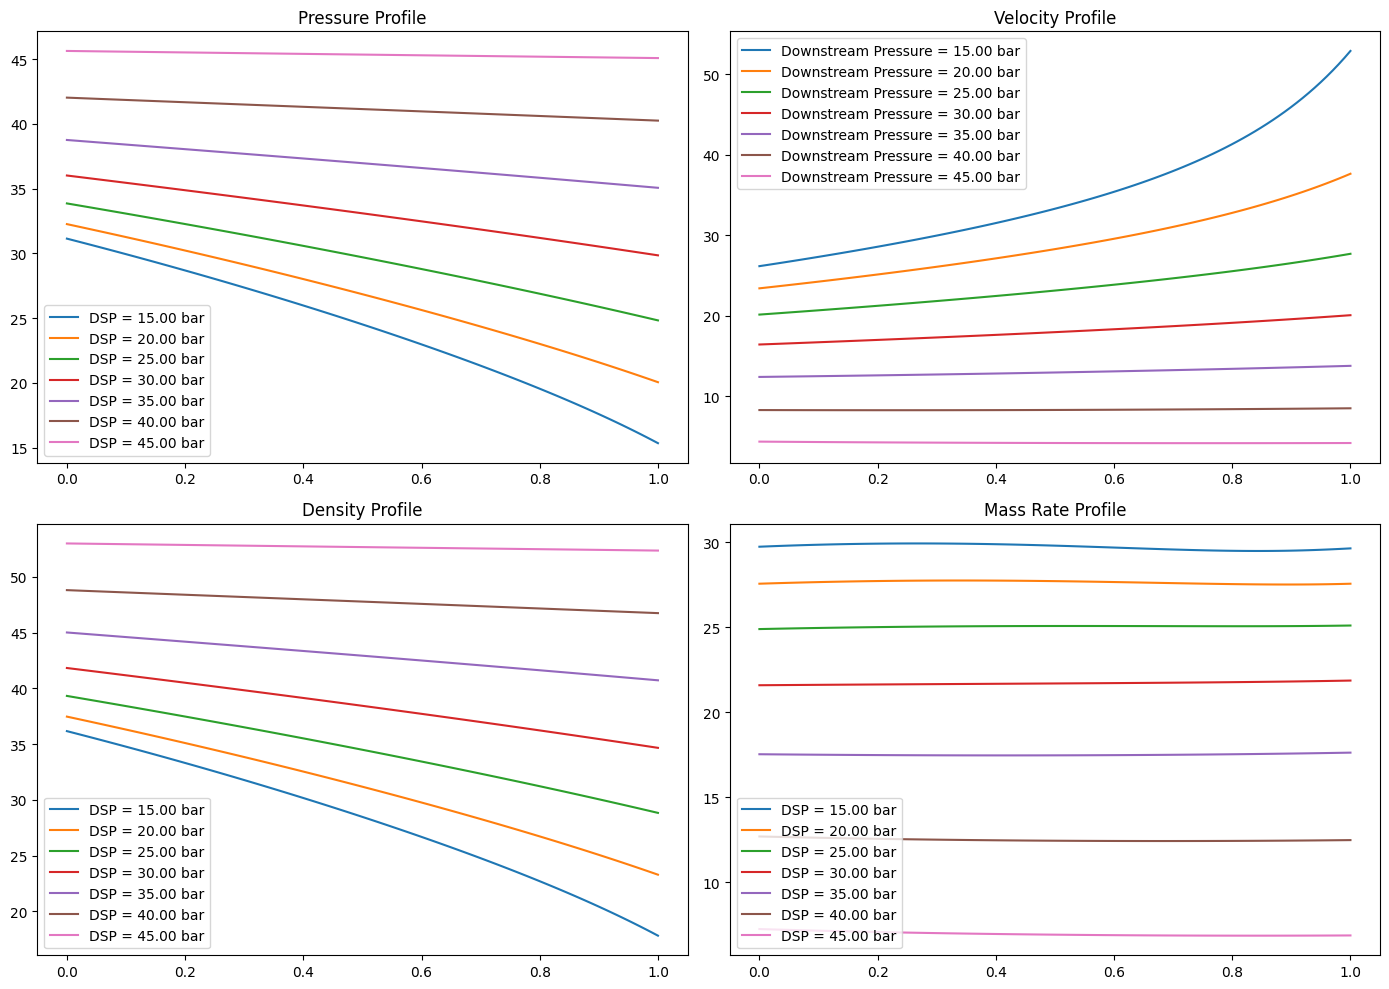

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

model.eval()  # Set the model to evaluation mode

# Define the x range from 0 to 1
x_values = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)

# Define u values ranging from 0.30 to 1.0 in steps of 0.10
u_values = torch.arange(0.30, 1.05, 0.10).reshape(-1, 1).to(device)

# Prepare the figure for plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Add titles to each subplot
axs[0, 0].set_title("Pressure Profile")
axs[0, 1].set_title("Velocity Profile")
axs[1, 0].set_title("Density Profile")
axs[1, 1].set_title("Mass Rate Profile")

# Loop over u values (excluding the last one)
for u in u_values[:-1]:
    u_sample = torch.ones_like(x_values).to(device) * u

    # Evaluate the PINN model over x for the current u value
    with torch.no_grad():
        predictions = model(x_values, u_sample)
        pressure_values = predictions[:, 0].cpu().numpy().squeeze()  # First output: pressure
        velocity_values = predictions[:, 1].cpu().numpy().squeeze()  # Second output: velocity
        density_values = pressure_values * P_ref / R / T

    # Convert x_values to numpy for plotting
    x_values_np = x_values.cpu().numpy().squeeze()

    # Subplot for pressure
    color = axs[0, 0].plot(
        x_values_np, pressure_values * P_ref / 1e+5, 
        label=f'DSP = {u.item() * P_ref / 1e+5:.2f} bar'
    )[0].get_color()
    

    # Subplot for velocity
    color = axs[0, 1].plot(
        x_values_np, velocity_values * V_ref, 
        label=f'Downstream Pressure = {u.item() * P_ref / 1e+5:.2f} bar'
    )[0].get_color()


    # Subplot for density
    color = axs[1, 0].plot(
        x_values_np, density_values, 
        label=f'DSP = {u.item() * P_ref / 1e+5:.2f} bar'
    )[0].get_color()


    # Subplot for mass flow rate
    pi = np.pi
    A = pi * D**2 / 4.0
    mass_rate = A * density_values * velocity_values * V_ref
    color = axs[1, 1].plot(
        x_values_np, mass_rate, 
        label=f'DSP = {u.item() * P_ref / 1e+5:.2f} bar'
    )[0].get_color()

#Add legends and adjust layout
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()
